In [1]:
# Dependencies
library(ggplot2)
library(dplyr)
library(tidyr)
library(infer)

# Read dataset from URL in CSV format
salaries = read.csv('https://ai-jobs.net/salaries/download/salaries.csv')

### Clean and tidy dataset
# Filter dataset such that remote_ratio is either 0 or 100
salaries_filtered <- salaries %>%
    filter(remote_ratio == 0 | remote_ratio == 100, !is.na(remote_ratio), !is.na(salary), 
           salary_currency == "USD") |>
    select(remote_ratio, salary_in_usd)

# Change column names
colnames(salaries_filtered) <- c("job_type", "salary_in_USD")
 
salaries_job_type <-  salaries_filtered |>
                       mutate(job_type = case_when(job_type == 100 ~ "Remote",
                              job_type == 0 ~ "In-Person")) |>
                              mutate(job_type = as.factor(job_type))
head(salaries_job_type)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,job_type,salary_in_USD
,<fct>,<int>
1,In-Person,133000
2,In-Person,58400
3,In-Person,141298
4,In-Person,115607
5,In-Person,100000
6,In-Person,75000


In [2]:
# Take a smaller sample from salaries_job_type

n_sample = 600
salaries_sample <-
    salaries_job_type %>%
    sample_n(size=n_sample, replace=FALSE)

head(salaries_sample)

,job_type,salary_in_USD
,<fct>,<int>
1,Remote,167200
2,In-Person,184950
3,Remote,120350
4,Remote,160000
5,In-Person,185000
6,Remote,146000


In [3]:
# Get the observed difference in medians between In-Person and Remote
obs_diff_in_sd <- 
    salaries_sample %>% 
    group_by(job_type) %>% 
    summarise(sd = sd(salary_in_USD)) %>%
    pivot_wider(names_from = job_type, values_from = sd) %>%
    transmute(diff = `Remote` - `In-Person`) %>%
    pull(diff)

obs_diff_in_sd

[1] -5510.765

In [10]:
# Specify number of bootstrap samples
n_bootstrap = 1000
n = nrow(salaries_sample)

# Create null model via bootstrap sampling
null_model <-
  salaries_sample %>%
  rep_sample_n(size=n, reps=n_bootstrap, replace=TRUE) %>%
  group_by(replicate, job_type) %>%
  summarise(sd_salary = sd(salary_in_USD)) %>%
  group_by(replicate) %>%
  summarise(diff_in_sd = diff(sd_salary)) %>%
  mutate(diff_in_sd = diff_in_sd + (0 - obs_diff_in_sd))

head(null_model)

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,diff_in_sd
<int>,<dbl>
1,788.2854
2,-581.3182
3,-237.1964
4,395.6215
5,1842.7037
6,-6863.0888


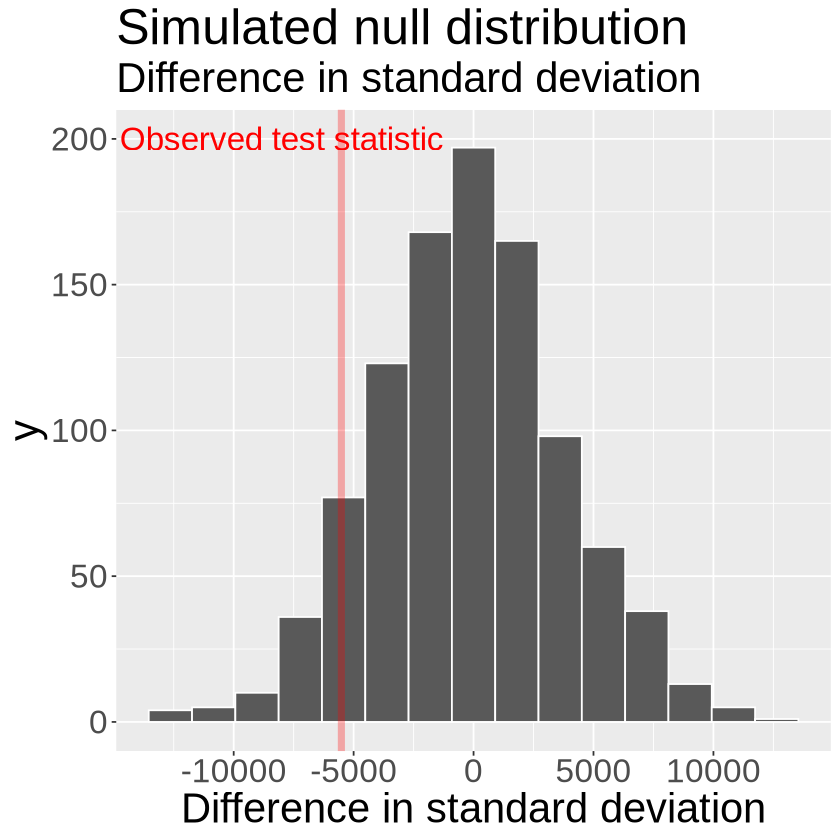

In [ ]:
# Plot the null model and 
null_model_plot <-
     null_model %>% 
     ggplot() +
     geom_histogram(aes(x=diff_in_sd), bins = 15, color="white") +
     geom_vline(xintercept = obs_diff_in_sd, color = "red", alpha=.3, lwd=2) + 
     xlab("Difference in standard deviation") + 
     theme(text = element_text(size=25)) + 
     ggtitle("Simulated null distribution", subtitle = "Difference in standard deviation")  +
     annotate("text", x = -8000, y = 200, label = "Observed test statistic", color="red", size=7)

null_model_plot

In [7]:
# Compute P-value from null model
p_value <- mean(null_model$diff_in_sd < -abs(obs_diff_in_sd) |
                null_model$diff_in_sd > abs(obs_diff_in_sd))

p_value

[1] 0.173

From the p-value, we do not reject the null hypothesis with significance $\alpha=0.05$.